In [1]:
##LETS TRY DOWNLOADING TINY IMAGENET 

## TASK AND OBJECTIVE 

Train ResNet18 on this dataset (70/30 split) for 50 Epochs. Target 50%+ Validation Accuracy.


# CHECK GPU

In [2]:
#STEP:1 
!nvidia-smi
!pip install --no-cache-dir git+https://github.com/albu/albumentations > /dev/null && echo "Albumentation library is successfully installed!"

Sun May  2 04:53:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
#STEP 2 :Import in built library 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import torchvision
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor

In [4]:
#STEP 3 : DELETE OLD GIT FOLDER AND CLONE NEW ONE 
%rm -r /content/SWAG_DNN
!git clone https://github.com/jitendramishra1024/SWAG_DNN.git
%cd SWAG_DNN

rm: cannot remove '/content/SWAG_DNN': No such file or directory
Cloning into 'SWAG_DNN'...
remote: Enumerating objects: 251, done.
remote: Counting objects: 100% (251/251), done.
remote: Compressing objects: 100% (179/179), done.
remote: Total 251 (delta 145), reused 169 (delta 68), pack-reused 0
Receiving objects: 100% (251/251), 228.43 KiB | 28.55 MiB/s, done.
Resolving deltas: 100% (145/145), done.
/content/SWAG_DNN


In [5]:
#STEP 4 :import userdefined library

from SWAG_DNN.utils import Dataloader 
from SWAG_DNN.utils import show_images
from SWAG_DNN.utils import classcount
from SWAG_DNN.utils import perClassResult
from SWAG_DNN.utils import plot_misclassified_image
from SWAG_DNN.utils import useful_utils
from SWAG_DNN.utils import gradcam
from SWAG_DNN.utils import Albumentations
from SWAG_DNN.utils.Albumentationtransform import AlbumentationTransforms
from SWAG_DNN.models import BasicModel
from SWAG_DNN.models import RESNET
from SWAG_DNN.trainer import train
from SWAG_DNN.trainer import test
from SWAG_DNN.utils.lr_finder import LRFinder
from SWAG_DNN.dataset import tinyimagenet
from SWAG_DNN.dataset.tinyimagenet import TinyImageNetDataSet
from SWAG_DNN.dataset.tinyimagenet import TinyImageNet


In [6]:
#STEP :5 Define parameters 

class Args:

    # Data Loading
    # ============
    
    num_workers = 4
    #batch_size = 512
    batch_size = 256
  


    # Regularization
    # ==============
    dropout = 0
    lambda_l2=5e-4
    lambda_l1=0

    # Training
    # ========
    random_seed = 1
    epochs = 30
    learning_rate = 0.01
    momentum = 0.9
    step_size=12

In [7]:
# down_url  = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
# tinyimagenet.download_images(down_url)
# classes = tinyimagenet.class_names(url = "tiny-imagenet-200/wnids.txt")
# dataset = TinyImageNet(classes,url="tiny-imagenet-200")
# mean,std = Dataloader.calculate_mean_std(dataset)
# print(mean)
# print(std)
mean = (0.442,0.442,0.442)
std = (0.278, 0.278, 0.278)

In [8]:
## STEP :5 ALBUMENTATION AND MEAN STD 
import albumentations as A
import cv2
channel_means = (0.442,0.442,0.442)
channel_stdevs = (0.278, 0.278, 0.278)
train_transform = AlbumentationTransforms([       
                                                                
                                      A.HorizontalFlip(p = 0.7),
                                      A.PadIfNeeded(min_height=70, min_width=70, border_mode=4, value=None, mask_value=None, always_apply=False, p=1.0),
                                      A.RandomCrop(64, 64, always_apply=False, p=1.0),
                                      A.Rotate(limit=30, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
                                      A.Normalize(mean=channel_means, std=channel_stdevs),
                                      A.Cutout(num_holes=1, max_h_size= 12,max_w_size = 12,p=0.7) 
                                       ])
test_transform = AlbumentationTransforms([A.Normalize(mean=channel_means, std=channel_stdevs)])

/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:645: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/pytorch/transforms.py:58: FutureWarning: ToTensor is deprecated and will be replaced by ToTensorV2 in albumentations 0.7.0
  "ToTensor is deprecated and will be replaced by ToTensorV2 in albumentations 0.7.0", FutureWarning


In [9]:
## STEP :6 : GET TRAIN TEST SET 

train_dataset , test_dataset,classes = TinyImageNetDataSet(train_split = 70,test_transforms = test_transform,train_transforms = train_transform)


In [10]:
classes=tinyimagenet.class_names()

In [11]:
url = "tiny-imagenet-200/words.txt"
f = open(url, "r")
words = [None] * 200
for line in f:
  wordclass = line.strip('\n').split('\t')[0]

  if wordclass in classes:
    i = classes.index(line.strip('\n').split('\t')[0])
    words[i] = line.strip('\n').split('\t')[1].split(',')[0]
classes=words

In [12]:
##STEP 7 :GET TRAIN AND TEST LOADER
trainloader, testloader = Dataloader.train_test_loaderV2(train_dataset,test_dataset,batch_size=Args.batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [13]:
len(trainloader),len(testloader)

(301, 129)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integ

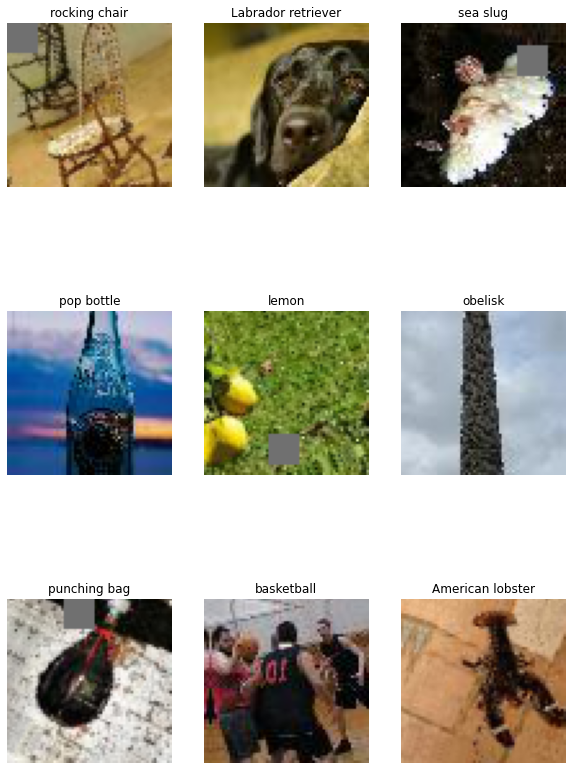

In [14]:
#STEP 8 :VISUALIZE DATA
show_images.plot_n_image(9,trainloader,classes,mean,std,format='raw')

In [15]:
#STEP :8 :PRINT SUMMARY
from SWAG_DNN.models import RESNET_1
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

model = RESNET_1.ResNet18(num_classes=200).to(device)
summary(model, input_size=(3, 64, 64))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1,

In [16]:
#STEP :9 : Loss AND OPTIMIZER
import torch.nn as nn
import torch.optim as optim
min_lr=1e-06
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(model.parameters(), lr=min_lr,momentum=Args.momentum,weight_decay=0.005 )

In [17]:
# # ###STEP 10 : Find BEST LR BETWEEN 10-6 and 10
# lr_finder = LRFinder(model, optimiser, criterion, device="cuda")
# ## FIND BEST LR AND PLOT BETWEEN 10-6 and 1 
# lr_finder.range_test(trainloader, val_loader=testloader,end_lr=1, num_iter=10 ,step_mode="exp")
# _,best_descent_lr=lr_finder.plot()
# ## Extract Best LR with minimum losss 
# Best_lr = lr_finder.history['lr'][lr_finder.history['loss'].index(lr_finder.best_loss)]
# print("best LR With steepest descent ", best_descent_lr)
# print("best LR With minimum loss ",Best_lr)
# lr_finder.reset() # to reset the model and optimizer to their initial state

In [18]:

#STEP 11 : 
## **Initialise Loss funtion, Optimizer, Scheduler**
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import OneCycleLR



optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9,weight_decay = 0.0001,nesterov = True ) 
criterion = nn.CrossEntropyLoss()
scheduler = OneCycleLR(optimizer, max_lr = 0.02, total_steps=None, epochs=30, steps_per_epoch=len(trainloader), pct_start=1/3, anneal_strategy='linear', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=10.0,final_div_factor =10)


In [19]:
#STEP 12 :TRAINING :

EPOCHS = Args.epochs

EPOCHS = 30
trainer = train.Trainer()
tester  = test.Tester()
Lr_track=[]
lossfunc=criterion

for epoch in range(EPOCHS):
  print("EPOCH:", epoch+1, 'LR:',optimizer.param_groups[0]['lr'])
  Lr_track.append(optimizer.param_groups[0]['lr'])
  trainer.train(model, device, trainloader, optimizer, lossfunc, epoch, Args.lambda_l1,scheduler)
  tester.test(model, device, testloader)

test_losses,test_acc=tester.getValuesTest()
train_losses,train_acc=trainer.getValuesTrain()

  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 1 LR: 0.002


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Train set: Loss=4.140685558319092 Batch_id=300 Accuracy=5.82: 100%|██████████| 301/301 [05:33<00:00,  1.11s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: -2.1536, Test Accuracy: 3344/33000 (10.13%)

EPOCH: 2 LR: 0.0038005982053838485


Train set: Loss=3.8498404026031494 Batch_id=300 Accuracy=14.08: 100%|██████████| 301/301 [05:37<00:00,  1.12s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: -2.9537, Test Accuracy: 4865/33000 (14.74%)

EPOCH: 3 LR: 0.005601196410767697


Train set: Loss=3.348512887954712 Batch_id=300 Accuracy=21.00: 100%|██████████| 301/301 [05:38<00:00,  1.12s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: -4.0602, Test Accuracy: 6552/33000 (19.85%)

EPOCH: 4 LR: 0.007401794616151546


Train set: Loss=3.0537030696868896 Batch_id=300 Accuracy=26.44: 100%|██████████| 301/301 [05:38<00:00,  1.12s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: -4.4605, Test Accuracy: 7461/33000 (22.61%)

EPOCH: 5 LR: 0.009202392821535395


Train set: Loss=2.9785475730895996 Batch_id=300 Accuracy=30.70: 100%|██████████| 301/301 [05:38<00:00,  1.12s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: -5.1577, Test Accuracy: 9367/33000 (28.38%)

EPOCH: 6 LR: 0.011002991026919245


Train set: Loss=2.7780959606170654 Batch_id=300 Accuracy=34.66: 100%|██████████| 301/301 [05:38<00:00,  1.12s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: -5.6872, Test Accuracy: 9800/33000 (29.70%)

EPOCH: 7 LR: 0.012803589232303092


Train set: Loss=2.5739128589630127 Batch_id=300 Accuracy=37.79: 100%|██████████| 301/301 [05:38<00:00,  1.12s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: -5.7921, Test Accuracy: 9448/33000 (28.63%)

EPOCH: 8 LR: 0.01460418743768694


Train set: Loss=2.240294933319092 Batch_id=300 Accuracy=40.56: 100%|██████████| 301/301 [05:39<00:00,  1.13s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: -7.0824, Test Accuracy: 10735/33000 (32.53%)

EPOCH: 9 LR: 0.01640478564307079


Train set: Loss=2.6254701614379883 Batch_id=300 Accuracy=43.12: 100%|██████████| 301/301 [05:38<00:00,  1.13s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: -7.1845, Test Accuracy: 11430/33000 (34.64%)

EPOCH: 10 LR: 0.01820538384845464


Train set: Loss=2.074977159500122 Batch_id=300 Accuracy=45.30: 100%|██████████| 301/301 [05:38<00:00,  1.13s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: -7.1369, Test Accuracy: 11855/33000 (35.92%)

EPOCH: 11 LR: 0.01999671096345515


Train set: Loss=2.0090646743774414 Batch_id=300 Accuracy=47.56: 100%|██████████| 301/301 [05:39<00:00,  1.13s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: -7.3938, Test Accuracy: 12888/33000 (39.05%)

EPOCH: 12 LR: 0.01900671096345515


Train set: Loss=1.7800838947296143 Batch_id=300 Accuracy=49.89: 100%|██████████| 301/301 [05:38<00:00,  1.13s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: -7.6359, Test Accuracy: 12885/33000 (39.05%)

EPOCH: 13 LR: 0.01801671096345515


Train set: Loss=2.133492946624756 Batch_id=300 Accuracy=51.95: 100%|██████████| 301/301 [05:39<00:00,  1.13s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: -7.6297, Test Accuracy: 13504/33000 (40.92%)

EPOCH: 14 LR: 0.01702671096345515


Train set: Loss=1.808852195739746 Batch_id=300 Accuracy=53.82: 100%|██████████| 301/301 [05:39<00:00,  1.13s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: -8.4204, Test Accuracy: 14128/33000 (42.81%)

EPOCH: 15 LR: 0.01603671096345515


Train set: Loss=1.956908106803894 Batch_id=300 Accuracy=55.82: 100%|██████████| 301/301 [05:38<00:00,  1.12s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: -8.4016, Test Accuracy: 14834/33000 (44.95%)

EPOCH: 16 LR: 0.01504671096345515


Train set: Loss=1.7255662679672241 Batch_id=300 Accuracy=57.53: 100%|██████████| 301/301 [05:38<00:00,  1.12s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: -8.7369, Test Accuracy: 14756/33000 (44.72%)

EPOCH: 17 LR: 0.014056710963455149


Train set: Loss=1.6431097984313965 Batch_id=300 Accuracy=59.42: 100%|██████████| 301/301 [05:38<00:00,  1.12s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: -9.0400, Test Accuracy: 15720/33000 (47.64%)

EPOCH: 18 LR: 0.01306671096345515


Train set: Loss=1.5120936632156372 Batch_id=300 Accuracy=61.06: 100%|██████████| 301/301 [05:38<00:00,  1.12s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: -9.4714, Test Accuracy: 15979/33000 (48.42%)

EPOCH: 19 LR: 0.012076710963455148


Train set: Loss=1.6234593391418457 Batch_id=300 Accuracy=62.61: 100%|██████████| 301/301 [05:38<00:00,  1.12s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: -9.2639, Test Accuracy: 15323/33000 (46.43%)

EPOCH: 20 LR: 0.011086710963455149


Train set: Loss=1.5548067092895508 Batch_id=300 Accuracy=64.39: 100%|██████████| 301/301 [05:38<00:00,  1.12s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: -9.6420, Test Accuracy: 16326/33000 (49.47%)

EPOCH: 21 LR: 0.010096710963455147


Train set: Loss=1.3663901090621948 Batch_id=300 Accuracy=66.21: 100%|██████████| 301/301 [05:38<00:00,  1.13s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: -9.7580, Test Accuracy: 16678/33000 (50.54%)

EPOCH: 22 LR: 0.00910671096345515


Train set: Loss=1.1819255352020264 Batch_id=300 Accuracy=67.84: 100%|██████████| 301/301 [05:38<00:00,  1.13s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: -9.9032, Test Accuracy: 16765/33000 (50.80%)

EPOCH: 23 LR: 0.008116710963455148


Train set: Loss=1.4777945280075073 Batch_id=300 Accuracy=69.73: 100%|██████████| 301/301 [05:38<00:00,  1.12s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: -9.8913, Test Accuracy: 16939/33000 (51.33%)

EPOCH: 24 LR: 0.00712671096345515


Train set: Loss=1.0659205913543701 Batch_id=300 Accuracy=71.67: 100%|██████████| 301/301 [05:39<00:00,  1.13s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: -10.3882, Test Accuracy: 17301/33000 (52.43%)

EPOCH: 25 LR: 0.006136710963455149


Train set: Loss=0.9025036692619324 Batch_id=300 Accuracy=73.60: 100%|██████████| 301/301 [05:38<00:00,  1.13s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: -10.1518, Test Accuracy: 17296/33000 (52.41%)

EPOCH: 26 LR: 0.005146710963455148


Train set: Loss=0.9125208854675293 Batch_id=300 Accuracy=76.03: 100%|██████████| 301/301 [05:39<00:00,  1.13s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: -10.4040, Test Accuracy: 17675/33000 (53.56%)

EPOCH: 27 LR: 0.00415671096345515


Train set: Loss=0.6526095867156982 Batch_id=300 Accuracy=78.26: 100%|██████████| 301/301 [05:38<00:00,  1.12s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: -10.8388, Test Accuracy: 17411/33000 (52.76%)

EPOCH: 28 LR: 0.0031667109634551487


Train set: Loss=0.7821012735366821 Batch_id=300 Accuracy=80.70: 100%|██████████| 301/301 [05:38<00:00,  1.12s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: -10.6887, Test Accuracy: 17809/33000 (53.97%)

EPOCH: 29 LR: 0.002176710963455151


Train set: Loss=0.6229172945022583 Batch_id=300 Accuracy=83.50: 100%|██████████| 301/301 [05:37<00:00,  1.12s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: -10.9915, Test Accuracy: 18533/33000 (56.16%)

EPOCH: 30 LR: 0.0011867109634551495


Train set: Loss=0.48839011788368225 Batch_id=300 Accuracy=86.18: 100%|██████████| 301/301 [05:38<00:00,  1.13s/it]



Test set: Average loss: -11.0401, Test Accuracy: 18762/33000 (56.85%)



In [20]:
new_train_acc,new_train_loss=useful_utils.modify_train_loss_accuracy_from_batch_level_to_epoch_level(train_acc,train_losses,trainloader)

train_acc_mod=new_train_acc
train_losses_mod=new_train_loss
len(train_acc_mod),len(train_losses_mod),len(new_train_loss),len(Lr_track)

(30, 30, 30, 30)

In [21]:
import matplotlib.pyplot as plt
def plot_lr_metric(lr_metric):
    plt.figure(figsize=(7, 5))
    plt.plot(lr_metric)
    plt.title('Learning Rate')
    plt.show()

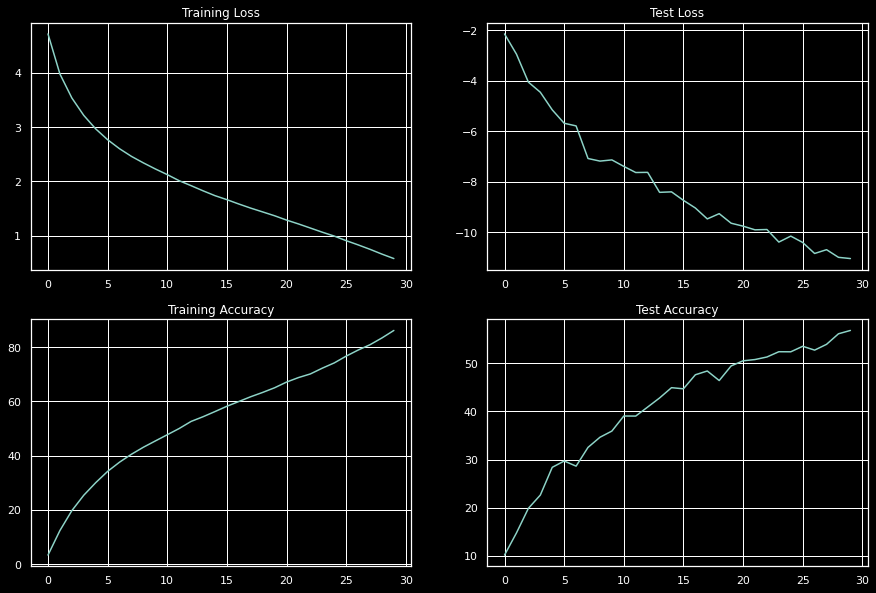

In [22]:
def plot_train_test_loss_accuracy(train_losses_mod,train_acc_mod,test_losses,test_acc):
  import seaborn as sns
  import matplotlib.pyplot as plt
  sns.set()
  plt.style.use("dark_background")

  fig, axs = plt.subplots(2,2,figsize=(15,10))
  axs[0, 0].plot(train_losses_mod)
  axs[0, 0].set_title("Training Loss")
  axs[1, 0].plot(train_acc_mod)
  axs[1, 0].set_title("Training Accuracy")
  axs[0, 1].plot(test_losses)
  axs[0, 1].set_title("Test Loss")
  axs[1, 1].plot(test_acc)
  axs[1, 1].set_title("Test Accuracy")
  plt.show()

plot_train_test_loss_accuracy(train_losses_mod,train_acc_mod,test_losses,test_acc)

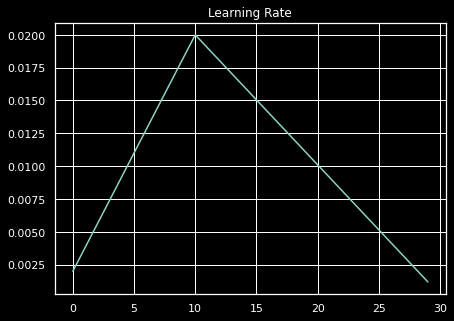

In [23]:

plot_lr_metric(Lr_track)

In [24]:
def get_percent_acc_each_class(model,device,classes,testloader,numclasses=10):
  class_correct = list(0 for i in range(numclasses))
  class_total = list(1 for i in range(numclasses))
  with torch.no_grad():
      for images,labels in testloader:
          #images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs, 1)
          c = (predicted == labels).squeeze()
          for i in range(4):
              label = labels[i]
              class_correct[label] += c[i].item()
              class_total[label] += 1


  for i in range(numclasses):
      print('Accuracy of %5s : %2d %%' % (
          classes[i], 100 * class_correct[i] / class_total[i]))

In [25]:
# dataiter = iter(trainloader)
# images, labels = dataiter.next()
# labels


In [26]:
#GET PERCENTAGE ACCURACY FOR EACH CLASS      
#perClassResult.get_percent_acc_each_class(model,device,classes,testloader,numclasses)
get_percent_acc_each_class(model,device,classes,testloader,len(classes))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy of Egyptian cat :  0 %
Accuracy of  reel : 50 %
Accuracy of volleyball : 25 %
Accuracy of rocking chair : 42 %
Accuracy of lemon : 40 %
Accuracy of bullfrog : 50 %
Accuracy of basketball : 50 %
Accuracy of cliff :  0 %
Accuracy of espresso : 75 %
Accuracy of plunger : 50 %
Accuracy of parking meter : 60 %
Accuracy of German shepherd : 75 %
Accuracy of dining table : 25 %
Accuracy of monarch : 66 %
Accuracy of brown bear : 83 %
Accuracy of school bus : 50 %
Accuracy of pizza : 60 %
Accuracy of guinea pig : 66 %
Accuracy of umbrella : 25 %
Accuracy of organ :  0 %
Accuracy of  oboe : 40 %
Accuracy of maypole : 66 %
Accuracy of goldfish : 83 %
Accuracy of potpie : 40 %
Accuracy of hourglass : 50 %
Accuracy of seashore :  0 %
Accuracy of computer keyboard : 71 %
Accuracy of Arabian camel :  0 %
Accuracy of ice cream : 25 %
Accuracy of  nail : 33 %
Accuracy of space heater :  0 %
Accuracy of cardigan : 50 %
Accuracy of baboon : 25 %
Accuracy of snail : 66 %
Accuracy of coral reef :

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integ

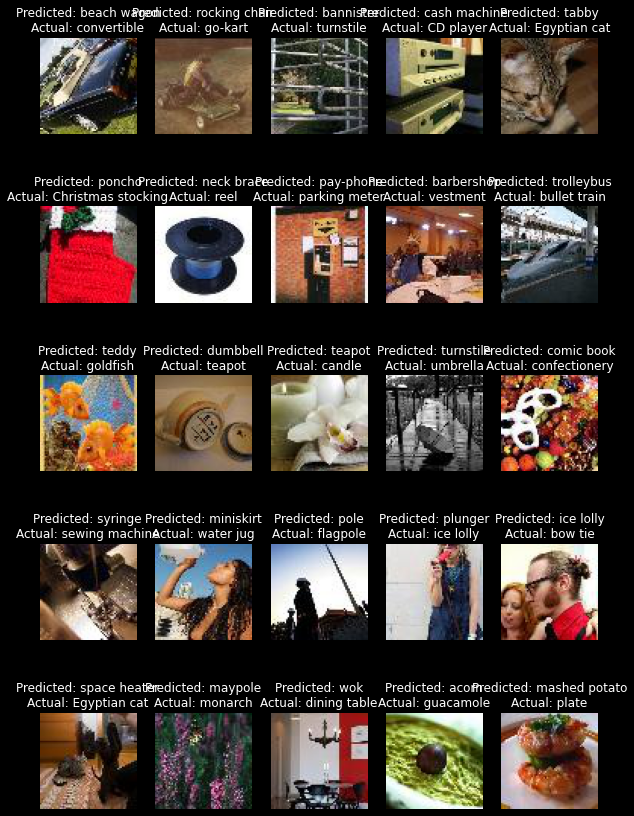

In [27]:
#Plot misclassified Image
plot_misclassified_image.plot_misclassified(25, testloader, device,model,classes,mean,std,format='raw')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is depr

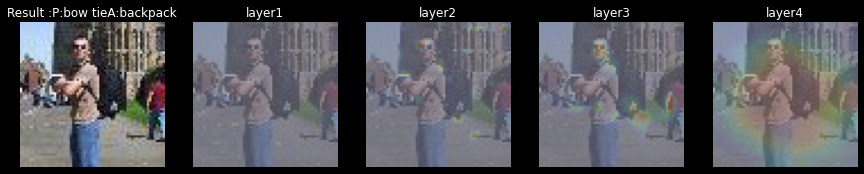

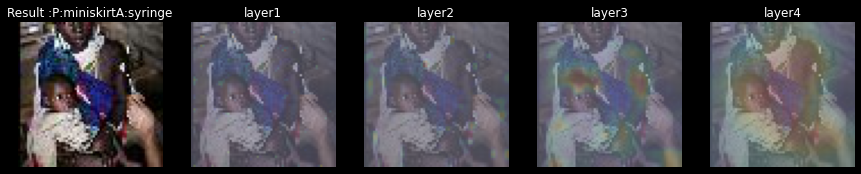

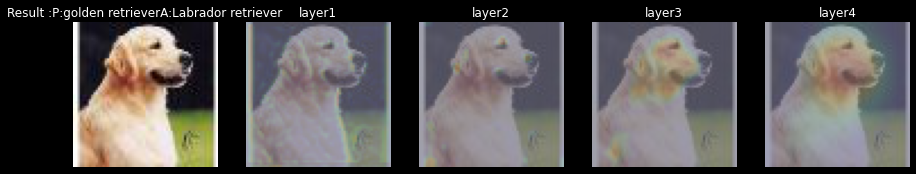

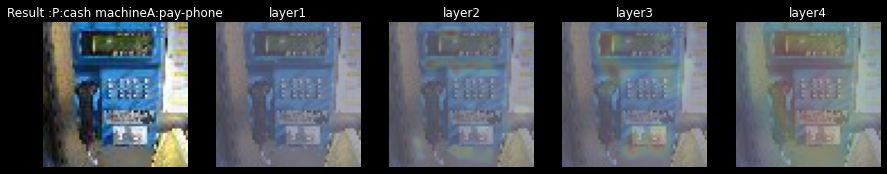

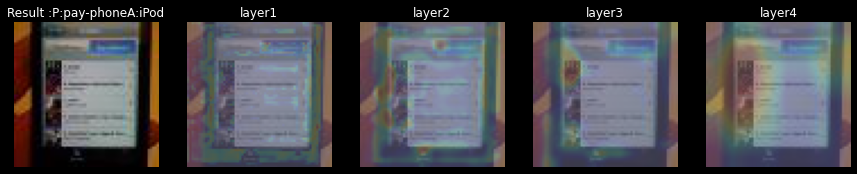

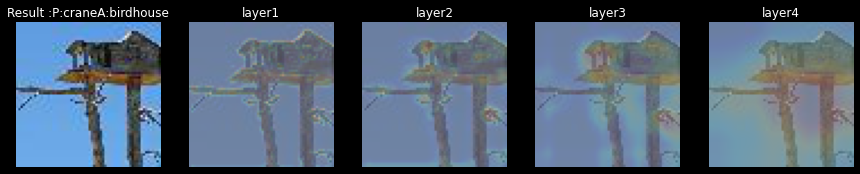

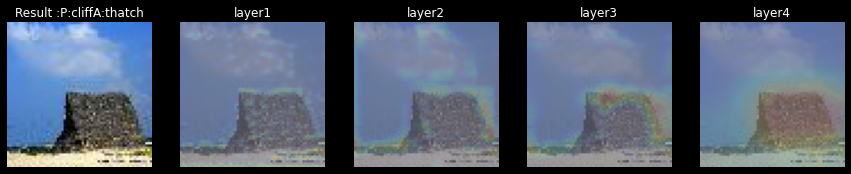

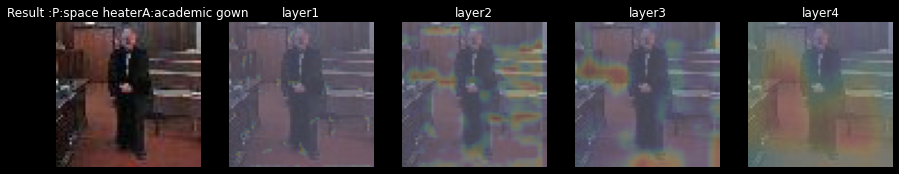

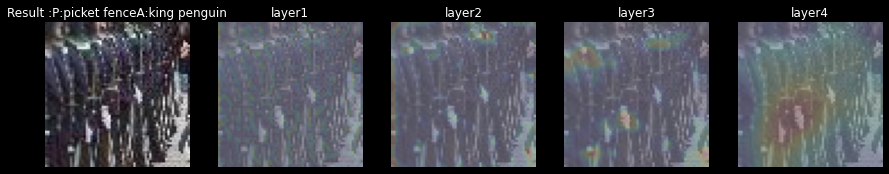

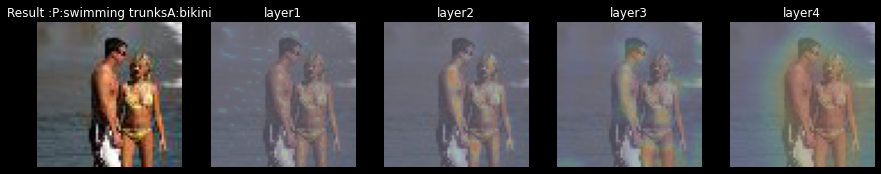

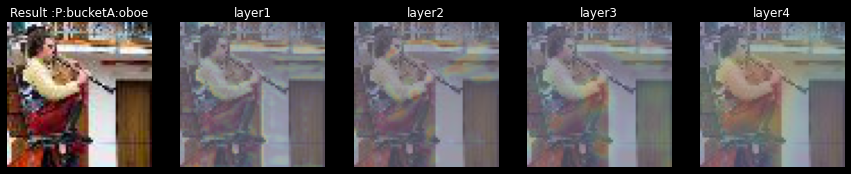

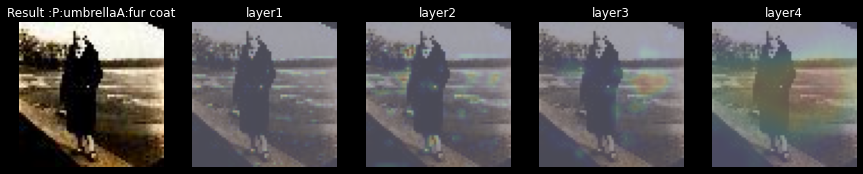

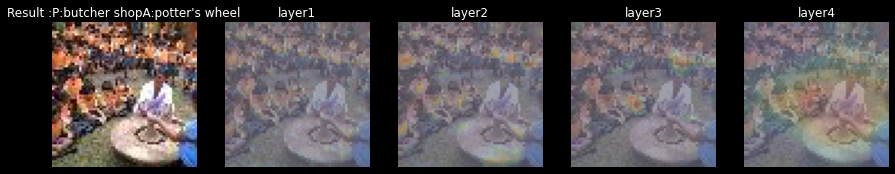

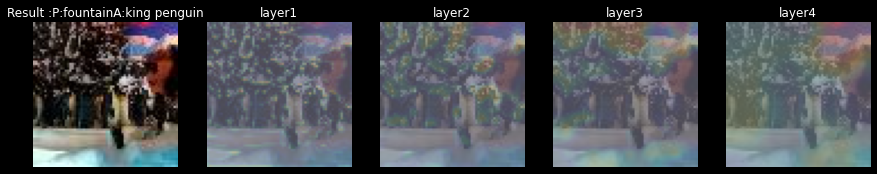

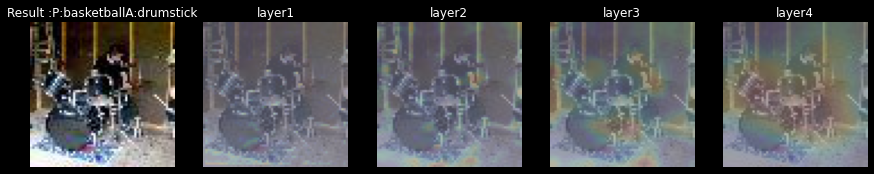

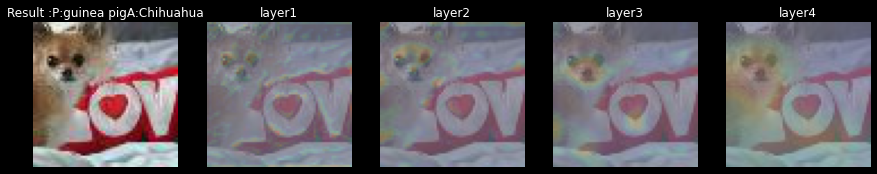

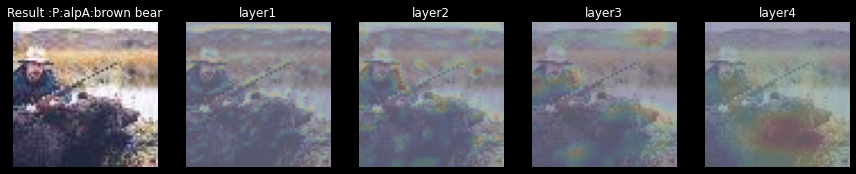

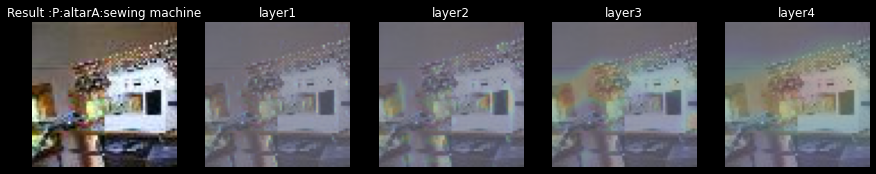

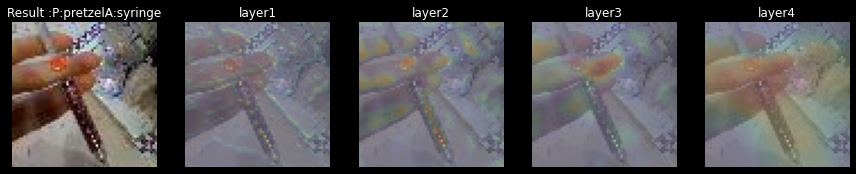

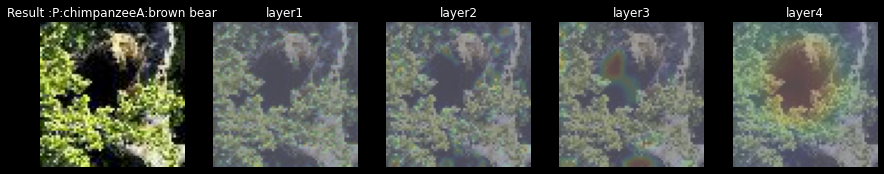

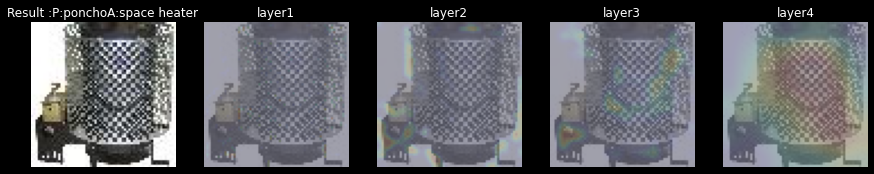

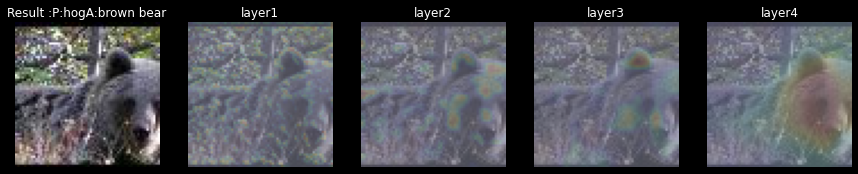

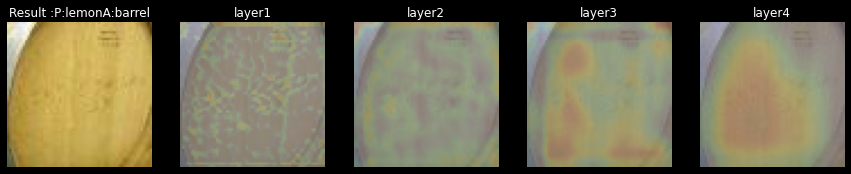

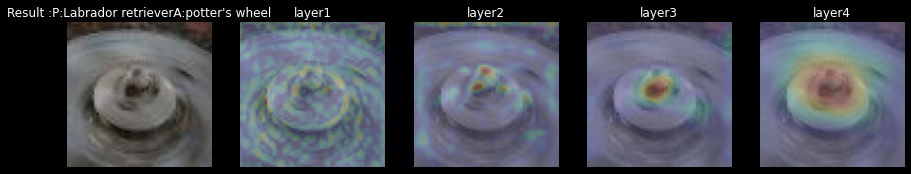

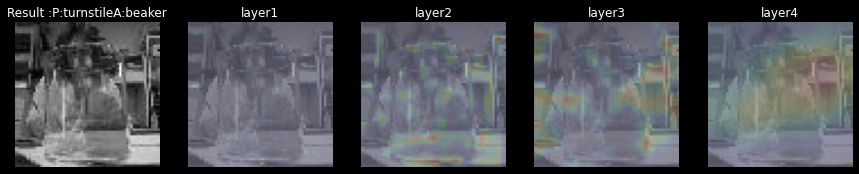

In [28]:
missed_images, predicted, actual = plot_misclassified_image.get_misclassified(model,testloader,device)

#lets see gradcam of  4 misclassified images 
gradcam.show_gradcam_for_n_images_only_result(25,missed_images,predicted,actual,classes,model,device,mean,std,img_size=64)